# Training a DQN on `intersection-v0`
## Import requirements

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Environment
!pip install highway-env
import gym
import highway_env

!apt-get update
!apt-get install xvfb
!apt-get install x11-utils
!apt-get install ffmpeg
!apt-get install python-opengl 
!pip -q install gym pyvirtualdisplay pygame



#import pygame
gym.logger.set_level(40) # suppress warnings on gym

# Models and computation
import torch # will use pyTorch to handle NN 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from collections import deque
import random
from random import sample

# Visualization
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor
import base64

# IO
from pathlib import Path
import os 

     |████████████████████████████████| 92kB 7.9MB/s 
     |████████████████████████████████| 11.8MB 32.9MB/s 
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http:

In [5]:
display = Display(visible=0, size=(600, 400))
display.start()

def show_video(path):
    html = []
    for mp4 in Path(path).glob("*.mp4"):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append('''<video alt="{}" autoplay 
                      controls style="height: 400px;">
                      <source src="data:video/mp4;base64,{}" type="video/mp4" />
                 </video>'''.format(mp4, video_b64.decode('ascii')))
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

In [6]:
env = gym.make("intersection-v0")
env = Monitor(env, './video', force=True, video_callable=lambda episode: True)
env.reset()
done = False
while not done:
    action = env.action_space.sample()#env.action_space.sample()
    obs, reward, done, info = env.step(action)
env.close()
show_video('./video')

## Training

Prepare environment, agent, and evaluation process.

We use a policy architecture based on social attention, see [[Leurent and Mercat, 2019]](https://arxiv.org/abs/1911.12250).


In [7]:
print(env.action_space)
print(env.observation_space)

Discrete(3)
Box(-1.0, 1.0, (15, 7), float32)


In [8]:
from google.colab import drive
from google.colab import files

def save_checkpoint(model, filename, mode=0):
    """
    Save a model to a file in your colab space 
        
    Parameters
    ----------
    model: your Q network
    filename: the name of the checkpoint file
    mode (int): determines where to store the file
                --> 0: collab space 1: Google Drive
    """
    if mode == 1: 
      drive.mount('/content/gdrive')
      path = F"/content/gdrive/My Drive/{filename}" 
      torch.save(model.state_dict(), path)
    else:
      torch.save(model.state_dict(), filename)

def export_to_local_drive(filename):
    """
    Download a file to your local machine 
        
    Parameters
    ----------
    filename: the name of the file
    """
    files.download(filename)

# New Section

## Testing

Run the learned policy for a few episodes.

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from collections import namedtuple

######################## Your code ####################################
# class for QNetwork
class QNetwork(nn.Module): 
    def __init__(self, s_size,  a_size, fc1_units=32, fc2_units=32):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(s_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, a_size)

    def forward(self, state):
        """Perform forward propagation."""

        x = state
        # print('intial', x)
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, 
                             device=device, 
                             dtype=torch.float32)
            x = x.unsqueeze(0)
        # print(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x 


In [10]:
class DQNAgent():
    def __init__(self, state_size, action_size, batch_size, epochs, lr):
        self.state_size = state_size
        self.action_size = action_size
        self.batch_size = batch_size
        self.epochs = epochs
        self.lr = lr
        self.experiences_position = 0
        # Q-Network (this could also be passed in the initialization)
        self.qnetwork = QNetwork(state_size, action_size, 512, 128).to(device)
        # Optimizer (this could also be passed in the initialization)
        self.optimizer = optim.RMSprop(self.qnetwork.parameters(), lr=self.lr)

    def epsilon_greedy_action(self, state, eps):
        """
        Returns either a random action or the greedy action.
        """
        with torch.no_grad():
            q_values = self.qnetwork(state).cpu().detach().data.numpy().squeeze()

        if np.random.rand() > eps:
            action = np.argmax(q_values)
        else: 
            action = np.random.randint(len(q_values))
        return action

    def greedy_action(self, state):
        """
        Returns the greedy action
        """
        with torch.no_grad():
            q_values = self.qnetwork(state).cpu().detach().data.numpy().squeeze()
        return np.argmax(q_values)

    def load_checkpoint(self, model_name):
        """
        Loads the model
        """
        self.qnetwork.load_state_dict(torch.load(model_name))

    def evaluate(self, env, n_rollouts=1):
        """
        Evaluates for n_rollouts #
        """
        rewards = []
        for _ in range(n_rollouts):
            state, done = env.reset(), False
            rewards.append(0)
            while not done:
                state = np.asarray(state).flatten()
                action = self.greedy_action(state)
                state, reward, done, _ = env.step(action)
                rewards[-1] += reward
        return np.mean(rewards), np.std(rewards)

    def collect_experience(self, env, state, eps):
        """
        Collects the experience (state, action, reward, new_state and is_terminal)
        """
        action = self.epsilon_greedy_action(state, eps)
        new_state, reward, is_terminal, info = env.step(action)
        # is_truncated = 'TimeLimit.truncated' in info
        new_state = np.asarray(new_state).flatten()
        experience = (state, action, reward, new_state, float(is_terminal)) 

        if len(self.experiences) < self.replay_capacity:
            self.experiences.append(None)
        self.experiences[self.experiences_position] = experience
        self.experiences_position = (self.experiences_position + 1) % self.replay_capacity

        self.episode_reward[-1] += reward
        self.episode_timestep[-1] += 1
        return new_state, is_terminal

    def learn(self, experiences):
        """
        Optimize the network parameters
        """
        states, actions, rewards, next_states, dones = experiences
        # print(states)
        q_predicted = self.qnetwork(states).gather(1, actions)
        # print(next_states.shape)
        q_next_states = target_net.qnetwork(next_states).detach()
        q_targets = q_next_states.max(1)[0].unsqueeze(1)
        q_target = rewards + (self.gamma*q_targets*(1-dones))

        loss = F.mse_loss(q_predicted, q_target)

        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def train(self, env, seed, gamma, max_episodes, target_update, replay_capacity):
        
        self.seed = seed
        self.gamma = gamma
        self.replay_capacity = replay_capacity
        torch.manual_seed =(self.seed)
        np.random.seed(self.seed)

        self.episode_reward = []
        self.evaluation_scores = []
        self.experiences = []
        self.episode_timestep = []
        total_steps = 0
        result = np.empty((max_episodes, 3))
        result[:] = np.nan
        eps = 1
        for episode in range(1, max_episodes+1):
            state, is_terminal = env.reset(), False
            self.episode_reward.append(0.0)
            self.episode_timestep.append(0.0)
            
            for step in range(max_steps_per_episode):
                state = np.asarray(state).flatten()
                state, is_terminal = self.collect_experience(env, state, eps)
                if len(self.experiences) >= self.batch_size:
                    experiences = np.array(random.sample(self.experiences, self.batch_size), dtype=object)

                    batches = [np.vstack(e) for e in experiences.T]
                    states, actions, rewards, new_states, is_terminals = batches
                    # print(states.shape, new_states.shape)
                    # load the dataset to the device
                    states = torch.from_numpy(states).float().to(device)
                    actions = torch.from_numpy(actions).long().to(device)
                    new_states = torch.from_numpy(new_states).float().to(device)
                    rewards = torch.from_numpy(rewards).float().to(device)
                    is_terminals = torch.from_numpy(is_terminals).float().to(device)
                    experiences = (states, actions, rewards, new_states, is_terminals) 
                    # print(experiences.shape)
                    self.learn(experiences)
                
                total_steps += 1
                if total_steps % target_update == 0:    # Updating the target_net parameters
                    target_net.qnetwork.load_state_dict(self.qnetwork.state_dict())

                
                if ((total_steps % 75) == 0) and (eps > 0.05):   # Epsilon decay by 0.005 every 75 steps, epsilon decays till 0.05
                    eps -= 0.005

                if is_terminal:
                    break

            # bookkeeping
            evaluation_score, _ = self.evaluate(env)
            self.evaluation_scores.append(evaluation_score)
            mean_100_reward = np.mean(self.episode_reward[-100:])
            std_100_reward = np.std(self.episode_reward[-100:])
            mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
            std_100_eval_score = np.std(self.evaluation_scores[-100:])
            result[episode-1] = total_steps, mean_100_reward, mean_100_eval_score
            print('Episode: {:d}, Total Steps: {:d}, Train_reward: {:.2f}, Eval_reward: {:.2f}, Epsilon: {:.4f}'.format(episode-1,total_steps,\
            mean_100_reward, mean_100_eval_score, eps))

            
        print('*****************Training Complete************************')
        save_checkpoint(policy_net.qnetwork, 'model_que1.pth')   # save the check point
        print('********************Model Saved************************')
        # export_to_local_drive('model_que1.pth')
        env.close()
        # show_video('./video')
        return result


In [ ]:
env = gym.make("intersection-v0")
batch_size = 128
epochs = 40
lr = 5e-4
gamma = 0.999
seed = 5
env.seed(seed)
max_episodes = 1000
max_steps_per_episode = 1000
target_update = 500
replay_capacity = 10000

# Initialize the weights of policy network and target network
# print(env.action_space.n)
policy_net = DQNAgent(105, env.action_space.n, batch_size, epochs, lr)
target_net = DQNAgent(105, env.action_space.n, batch_size, epochs, lr)
target_net.qnetwork.load_state_dict(policy_net.qnetwork.state_dict())

result = policy_net.train(env, seed, gamma, max_episodes, target_update, replay_capacity)
env.close()

del env

In [ ]:
env = gym.make('intersection-v0')
env = Monitor(env, './video', force=True, video_callable=lambda episode: True)
batch_size = 128
epochs = 40
lr = 5e-4

policy_net = DQNAgent(105, env.action_space.n, batch_size, epochs, lr)
policy_net.load_checkpoint('model_que1.pth')
state = env.reset()
done = False
while not done:
    state = np.asarray(state).flatten()
    action = policy_net.greedy_action(state)
    state, reward, done, _ = env.step(action)
    # print(action)
    # print("***************")
    # print(reward)
env.close()
show_video('./video')

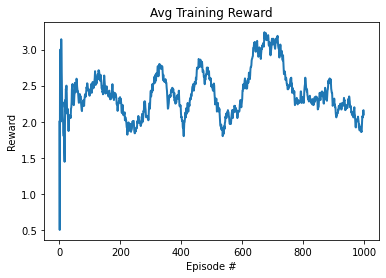

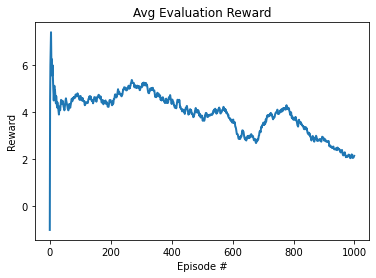

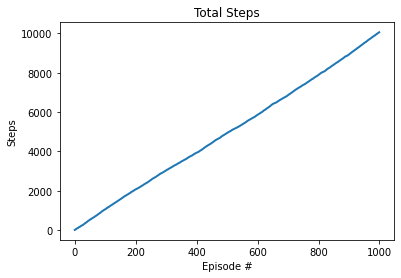

In [ ]:
nfq_steps, nfq_r, nfq_score = result.T


fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
plt.plot(nfq_r, linewidth=2)
plt.ylabel('Reward')
plt.xlabel('Episode #')
ax1.set_title('Avg Training Reward')


fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
plt.plot(nfq_score, linewidth=2)
plt.ylabel('Reward')
plt.xlabel('Episode #')
ax2.set_title('Avg Evaluation Reward')

fig3 = plt.figure()
ax3 = fig3.add_subplot(111)
plt.plot(nfq_steps, linewidth=2)
plt.ylabel('Steps')
plt.xlabel('Episode #')
ax3.set_title('Total Steps')


plt.show()